In [14]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split
from keras import layers, Model
from keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers, layers, losses
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, PrecisionRecallDisplay
from keras.utils import plot_model
import pandas as pd
import seaborn as sns
import joblib

(39000, 14)
(40000, 14)


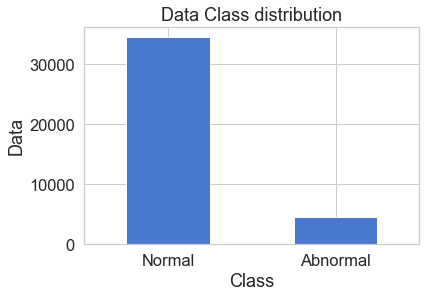

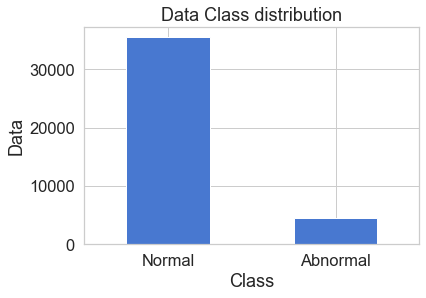

In [15]:
# Generate some sample data for the autoencoder
# x_train = np.random.rand(1000, 12)
# x_test = np.random.rand(100, 12)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42

df = pd.read_csv("Autoencoder1.csv")  
print(df.shape)

df2 = pd.read_csv("Autoencoder_wind.csv")  
print(df2.shape)

LABELS = ["Normal", "Abnormal"]

count_classes =pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

count_classes2 =pd.value_counts(df2['Class'], sort = True)
count_classes2.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from cmath import pi

data = df.drop(['Time'], axis=1)
y_true = df['Class']

r2d = 180/pi

data['P'] = r2d * data['P']
data['Q'] = r2d * data['Q']
data['R'] = r2d * data['R']
data['Phi'] = r2d * data['Phi']
data['Theta'] = r2d * data['Theta']
data['Psi'] = r2d * data['Psi']

data2 = df2.drop(['Time'], axis=1)
y_true2 = df2['Class']

r2d = 180/pi

data2['P'] = r2d * data2['P']
data2['Q'] = r2d * data2['Q']
data2['R'] = r2d * data2['R']
data2['Phi'] = r2d * data2['Phi']
data2['Theta'] = r2d * data2['Theta']
data2['Psi'] = r2d * data2['Psi']

In [16]:
X_train, X_test = train_test_split(data2, test_size=0.3, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = pd.DataFrame(X_train)
X_train = X_train.drop(['Class'], axis=1)

# X_test = X_test[X_test.Class == 0]
y_test = X_test['Class']
X_test = pd.DataFrame(X_test)
X_test = X_test.drop(['Class'], axis=1)

def normalize(label):
    str = StandardScaler()
    str.fit(X_train[label].values.reshape(-1, 1))
    X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
    X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

def normalize1(label):
    str = MinMaxScaler()
    str.fit(X_train[label].values.reshape(-1, 1))
    X_train[label] = str.transform(X_train[label].values.reshape(-1, 1))
    X_test[label] = str.transform(X_test[label].values.reshape(-1, 1))

A = ['RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'P', 'Q', 'R', 'Phi', 'Theta', 'Psi']

for i in A:
    normalize1(i)

X_train = X_train.values
X_test = X_test.values

In [37]:
def load_models1(Model_Name, AE_models, AE_Name, GMM_models, GMM_Name, rate):
    """load_models(Model_Name, AE_models, AE_Name, GMM_models)
    
        Args: 저장한 모델을 불러와서 검증 데이터를 분류한 결과를 변수에 저장하는 함수
        Model_Name (string): 분류 결과 데이터를 저장할 변수 이름
        AE_models (string): 저장한 오토인코더 모델 파일
        AE_Name (string): 저장한 오토인코더 모델을 할당할 변수 이름
        GMM_models (string): 저장한 GMM 모델 파일
        GMM_Name (string): 저장한 GMM 모델을 할당할 변수 이름
        rate (int): 이상판단의 기준치를 정하기 위한 신뢰구간 비율

    Returns: df
        Dictionary: df{ 'Model_name': [{'rate': [{ [dic1, dic2] }] }] }
        df[m]: Model_Name이 m인 모델
        df[m][0]: Model_Name이 m인 모델의 dic = [dic1, dic2] 데이터
        df[m][0][n]: Model_Name이 m인 모델에서 rate가 n인 dic = [dic1, dic2] 데이터
        df[m][0][n][0]: Model_Name이 m인 모델에서 rate가 n인 dic1 데이터
        df[m][0][n][0]['fpr']: Model_Name이 m인 모델에서 rate가 n인 dic1에 있는 fpr 데이터
    """
    for j in AE_models:
        for k in AE_Name:
            k = load_model(j)
            encoded_test_data = k.encoder(X_test).numpy()
            
            for i in GMM_models:
                for l in GMM_Name:
                    l = joblib.load(i)
                    scores=l.score_samples(encoded_test_data)
                    dic = {}
                    df = {}
                    
                    for m in Model_Name:
                        for n in rate:
                            
                            threshold = np.percentile(scores, n)
                            y_pred = np.zeros_like(scores)
                            y_pred[scores < threshold] = 1
                            precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred)
                            fpr, tpr, thresholds2 = roc_curve(y_test, y_pred)
                            roc_auc = auc(fpr, tpr)
                            f1 = f1_score(y_test, y_pred)
                            conf_matrix = confusion_matrix(y_test, y_pred)
                            
                            dic1 = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
                            dic2 = {'precision': precision, 'recall': recall, 'f1': f1, 'conf_matix': conf_matrix}
                            dic[n] = [dic1, dic2]
                        
                        df[m] = [dic]
                    
    return df

def load_models2(Model_Name, AE_models, AE_Name):
    """load_models(Model_Name, AE_models, AE_Name, GMM_models)
    
        Args: 저장한 모델을 불러와서 검증 데이터를 분류한 결과를 변수에 저장하는 함수
        Model_Name (string): 분류 결과 데이터를 저장할 변수 이름
        AE_models (string): 저장한 오토인코더 모델 파일
        AE_Name (string): 저장한 오토인코더 모델을 할당할 변수 이름
        rate (int): 이상판단의 기준치를 정하기 위한 신뢰구간 비율

    Returns: df
        Dictionary: df{ 'Model_name': [{'rate': [{ [dic1, dic2] }] }] }
        df[m]: Model_Name이 m인 모델
        df[m][0]: Model_Name이 m인 모델의 dic1 데이터
        df[m][0]['fpr']: Model_Name이 m인 모델에서 dic1에 있는 fpr 데이터
    """
    for j in AE_models:
        for k in AE_Name:
            k = load_model(j)
            df = {}
            
            for m in Model_Name:
                
                pred1 = k.predict(X_train)
                pred2 = k.predict(X_test)
                mse = np.mean(np.power((X_train - pred1), 2), axis=1)
                mse2 = np.mean(np.power((X_test - pred2), 2), axis=1)
                rmse1 = np.sqrt(mse)
                rmse2 = np.sqrt(mse2)
                thresholds = max(rmse1)
                error_df = pd.DataFrame({'reconstruction_error': rmse2,
                                        'true_class': y_test})

                error_df.reconstruction_error = error_df.reconstruction_error >= thresholds
                error_df['reconstruction_error'] = error_df['reconstruction_error'].astype(int)

                y_pred = error_df.reconstruction_error
                precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred)
                fpr, tpr, thresholds2 = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)
                f1 = f1_score(y_test, y_pred)
                conf_matrix = confusion_matrix(y_test, y_pred)
                
                dic1 = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
                dic2 = {'precision': precision, 'recall': recall, 'f1': f1, 'conf_matix': conf_matrix}
                df[m] = [dic1, dic2]
            
    return df

def ROC_Curve1(df, Model_Name, rate):
    """ROC_Curve(df, Model_Name, rate)
    
    Args: 
        df (int): load_models에서 분류한 결과를 저장한 변수
        Model_Name (string): 분류 결과 데이터를 저장할 변수 이름
        rate (string): 이상판단의 기준치를 정하기 위한 신뢰구간 비율
    """
    for m in Model_Name:
        plt.figure()
        for n in rate:
            plt.plot(df[m][0][n][0]['fpr'], df[m][0][n][0]['tpr'], label='AUC= %0.4f'% df[m][0][n][0]['roc_auc'])
            plt.plot([0, 1], [0, 1], 'r--')
            plt.legend(loc='lower right', prop={'size': 10})
            plt.xlim([-0.001, 1.0])
            plt.ylim([0.0, 1.001])
            plt.title("ROC curve ({})".format(m))
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
    plt.show();

def ROC_Curve2(df, Model_Name):
    """ROC_Curve(df, Model_Name, rate)
    
    Args: 
        df (int): load_models에서 분류한 결과를 저장한 변수
        Model_Name (string): 분류 결과 데이터를 저장할 변수 이름
    """
    for m in Model_Name:
        plt.figure()
        plt.plot(df[m][0]['fpr'], df[m][0]['tpr'], label='AUC= %0.4f'% df[m][0]['roc_auc'])
        plt.plot([0, 1], [0, 1], 'r--')
        plt.legend(loc='lower right', prop={'size': 10})
        plt.xlim([-0.001, 1.0])
        plt.ylim([0.0, 1.001])
        plt.title("ROC curve ({})".format(m))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
    plt.show();

def Precision_Recall_Curve1(df, Model_Name, rate):
    """Precision_Recall_Curve(df, Model_Name, rate)
    
    Args: 
        df (int): load_models에서 분류한 결과를 저장한 변수
        Model_Name (string): 분류 결과 데이터를 저장할 변수 이름
        rate (string): 이상판단의 기준치를 정하기 위한 신뢰구간 비율
    """
    for m in Model_Name:
        plt.figure()
        for n in rate:
            plt.plot(df[m][0][n][1]['precision'], df[m][0][n][1]['recall'], label='F1 score= %0.4f'% df[m][0][n][1]['f1'])
            plt.legend(loc='lower left', prop={'size': 10})
            plt.xlim([-0.001, 1.0])
            plt.ylim([0.0, 1.001])
            plt.title("Precision-Recall curve ({})".format(m))
            plt.xlabel('Precision')
            plt.ylabel('Recall')
    plt.show();

def Precision_Recall_Curve2(df, Model_Name):
    """Precision_Recall_Curve(df, Model_Name, rate)
    
    Args: 
        df (int): load_models에서 분류한 결과를 저장한 변수
        Model_Name (string): 분류 결과 데이터를 저장할 변수 이름
    """
    for m in Model_Name:
        plt.figure()
        plt.plot(df[m][1]['precision'], df[m][1]['recall'], label='F1 score= %0.4f'% df[m][1]['f1'])
        plt.legend(loc='lower left', prop={'size': 10})
        # plt.xlim([-0.001, 1.0])
        # plt.ylim([0.0, 1.001])
        plt.title("Precision-Recall curve ({})".format(m))
        plt.xlabel('Precision')
        plt.ylabel('Recall')
    plt.show();

def Confusion_Matrix1(df, Model_Name, rate):
    """Confusion_Matrix(df, Model_Name, rate)
    
    Args: 
        df (int): load_models에서 분류한 결과를 저장한 변수
        Model_Name (string): 분류 결과 데이터를 저장할 변수 이름
        rate (string): 이상판단의 기준치를 정하기 위한 신뢰구간 비율
    """
    for m in Model_Name:
        for n in rate:
            LABELS = ["Normal", "Abnormal"]
            conf_matrix = df[m][0][n][1]['conf_matix']
            plt.figure(figsize=(6, 6))
            sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, 
                        annot=True, fmt="d", annot_kws={'size': 20}, cmap="YlGnBu", 
                        vmin=0, vmax=4000);
            plt.text(0.05, 0.1, 'True Positive Rate', color="red", fontsize=13, fontweight="bold")
            plt.text(1.05, 0.1, 'False Negative Rate', color="red", fontsize=13, fontweight="bold")
            plt.text(0.05, 1.1, 'False Positive Rate', color="red", fontsize=13, fontweight="bold")
            plt.text(1.05, 1.1, 'True Negative Rate', color="red", fontsize=13, fontweight="bold")
            plt.title("Confusion matrix (rate = %0.4f)"% n)
            plt.xlabel('Predicted class')
            plt.ylabel('True class')
    plt.show();    

def Confusion_Matrix2(df, Model_Name):
    """Confusion_Matrix(df, Model_Name, rate)
    
    Args: 
        df (int): load_models에서 분류한 결과를 저장한 변수
        Model_Name (string): 분류 결과 데이터를 저장할 변수 이름
    """
    for m in Model_Name:
        LABELS = ["Normal", "Abnormal"]
        conf_matrix = df[m][1]['conf_matix']
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, 
                    annot=True, fmt="d", annot_kws={'size': 20}, cmap="YlGnBu", 
                    vmin=0, vmax=4000);
        plt.text(0.05, 0.1, 'True Positive Rate', color="red", fontsize=13, fontweight="bold")
        plt.text(1.05, 0.1, 'False Negative Rate', color="red", fontsize=13, fontweight="bold")
        plt.text(0.05, 1.1, 'False Positive Rate', color="red", fontsize=13, fontweight="bold")
        plt.text(1.05, 1.1, 'True Negative Rate', color="red", fontsize=13, fontweight="bold")
        plt.title("Confusion matrix")
        plt.xlabel('Predicted class')
        plt.ylabel('True class')
    plt.show();    

375/375 [==============================] - 0s 683us/step


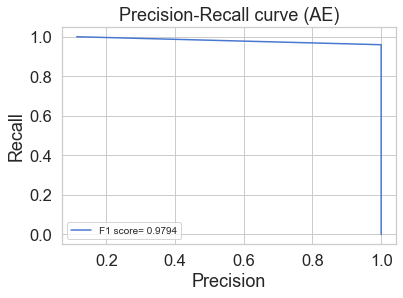

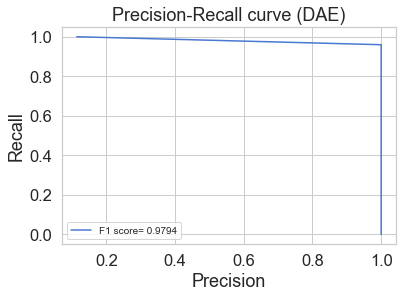

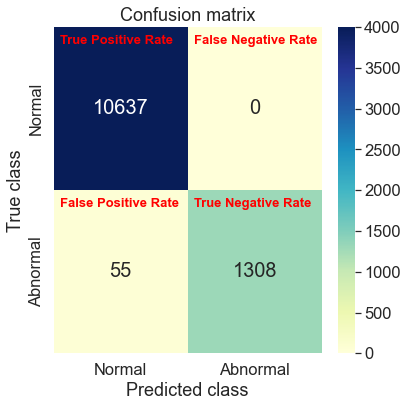

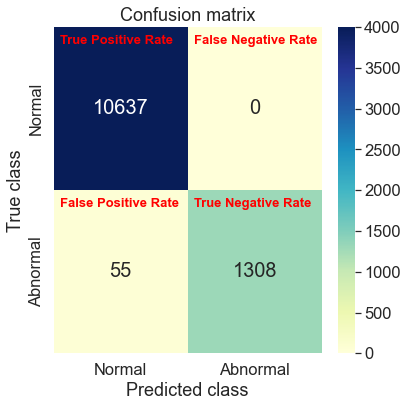

In [38]:
# rate = 11.6
rate = list(np.arange(10,13,0.2))

Model_Name = ["DAGMM1","DAGMM2"]
AE_models = ['DAGMM_AE','DAGMM_AE2']
AE_Name = ["DAGMM_AE1","DAGMM_AE2"]
GMM_models = ['DAGMM_GMM.pkl','DAGMM_GMM2.pkl']
GMM_Name = ['DAGMM_GMM1','DAGMM_GMM2']
# df1 = load_models1(Model_Name, AE_models, AE_Name, GMM_models, GMM_Name, rate)
# Precision_Recall_Curve1(df1, Model_Name, rate)
# Confusion_Matrix1(df1, Model_Name, rate)

Model_Name = ["AE","DAE"]
AE_models = ['AE','DAE']
AE_Name = ["AE","DAE"]
df2 = load_models2(Model_Name, AE_models, AE_Name)
Precision_Recall_Curve2(df2, Model_Name)
Confusion_Matrix2(df2, Model_Name)
# print(df["DAGMM1"])
# ROC_Curve(df, Model_Name, rate)